# QUBIC 1D
# TOD Realism
## JCH - Feb 2025
In this notebook we investigate the issue of TOD realism mentioned in `QUBIC-1D.ipynb`.

## Mandatory Imports

In [16]:
%matplotlib ipympl


import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
from importlib import reload    

from qubic.lib import Q1d as q1d 
from qubic.lib.Calibration.Qfiber import profile

sz = 10.
plt.rc('figure',figsize=(sz,sz/1.618))
plt.rc('font',size=10)
plt.rc('image', cmap='jet')

## Non-zero residuals with "exact" TOD_method - Why ?

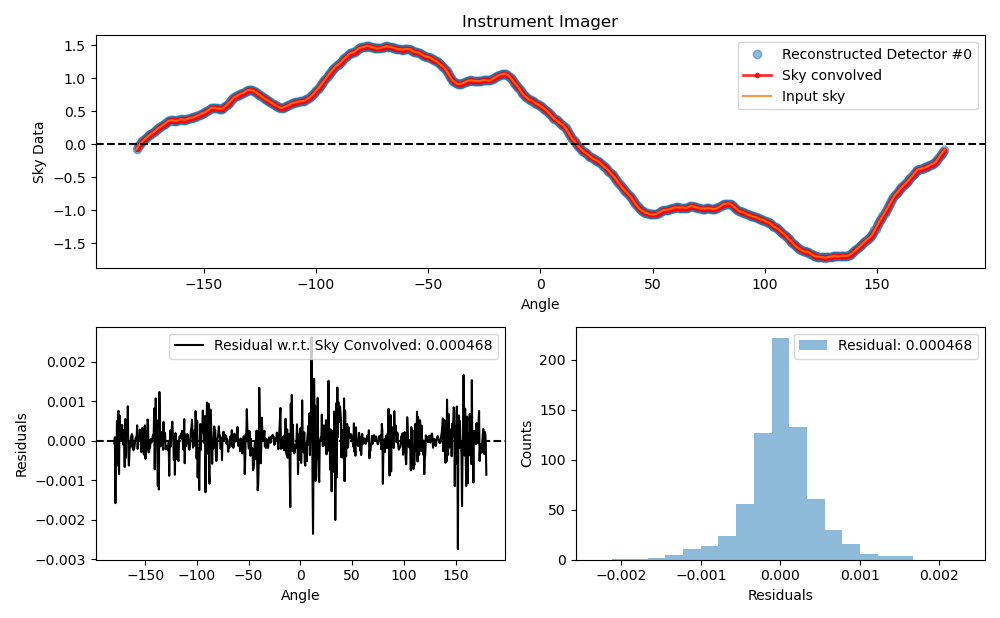

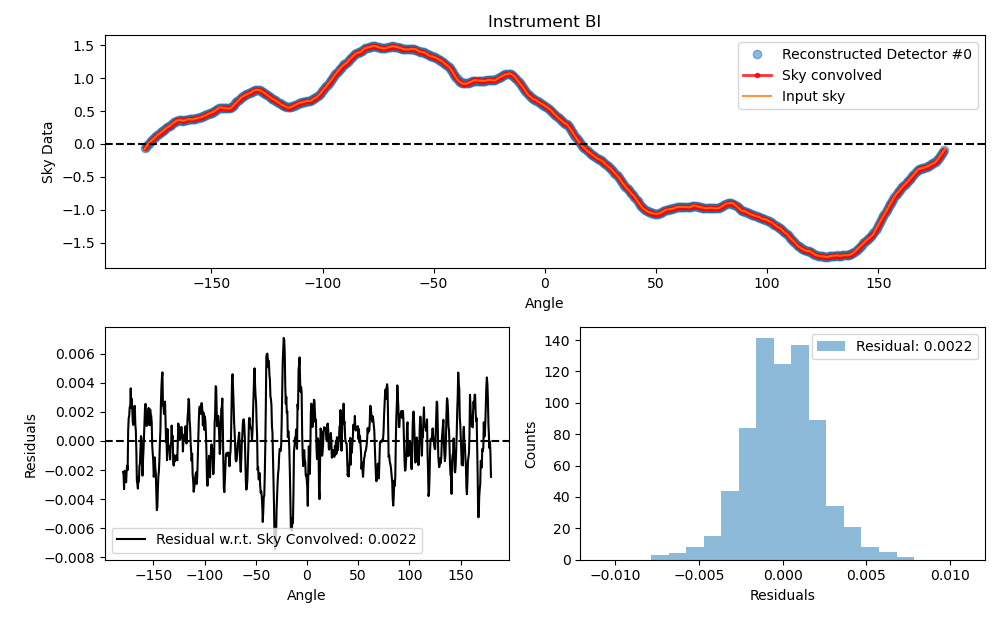

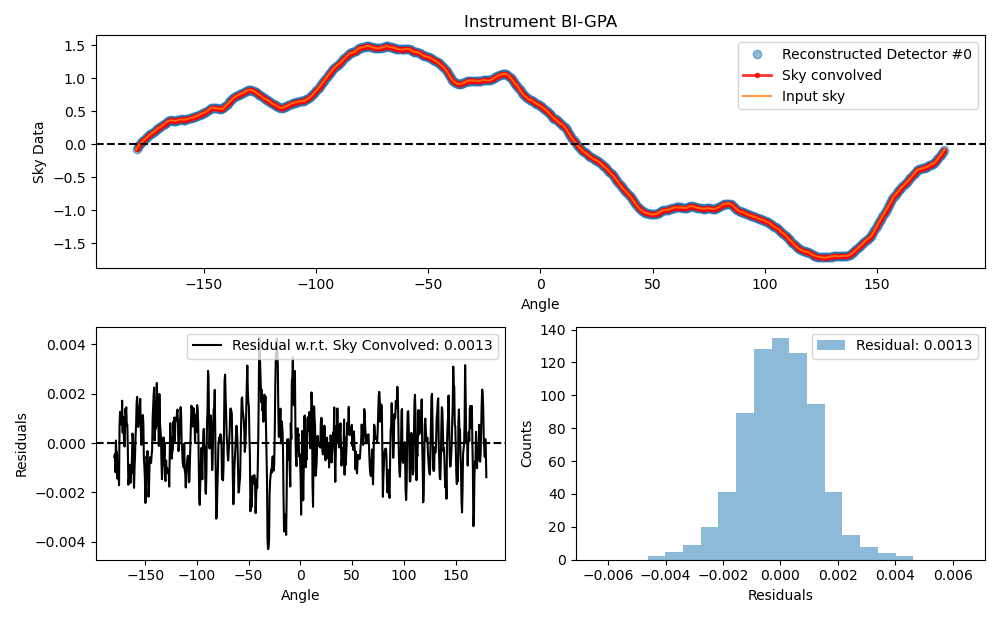

In [17]:
reload(q1d)
params = {'TOD_method':'exact'}
inst = q1d.Q1D(params=params, instrument_type='Imager', plot_sb=False)
res = inst.simulate_and_reconstruct()

inst = q1d.Q1D(params=params, instrument_type='BI', plot_sb=False)
res = inst.simulate_and_reconstruct()

inst = q1d.Q1D(params=params, instrument_type='BI-GPA', plot_sb=False)
res = inst.simulate_and_reconstruct()


## Explanation: TOD Fabrication realism issues w.r.t. TOD = H.d approximmation used in map-making.

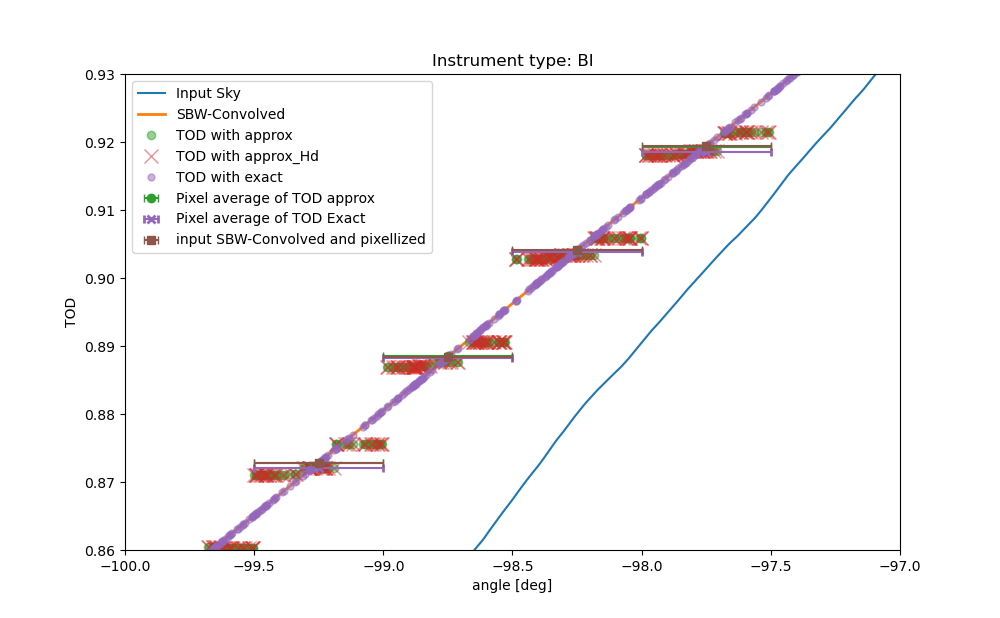

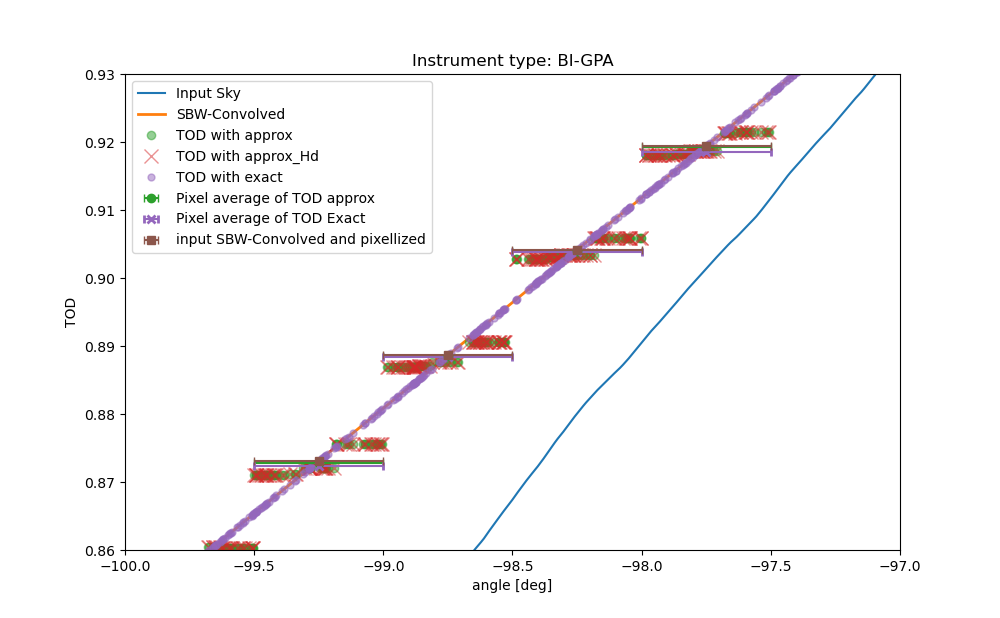

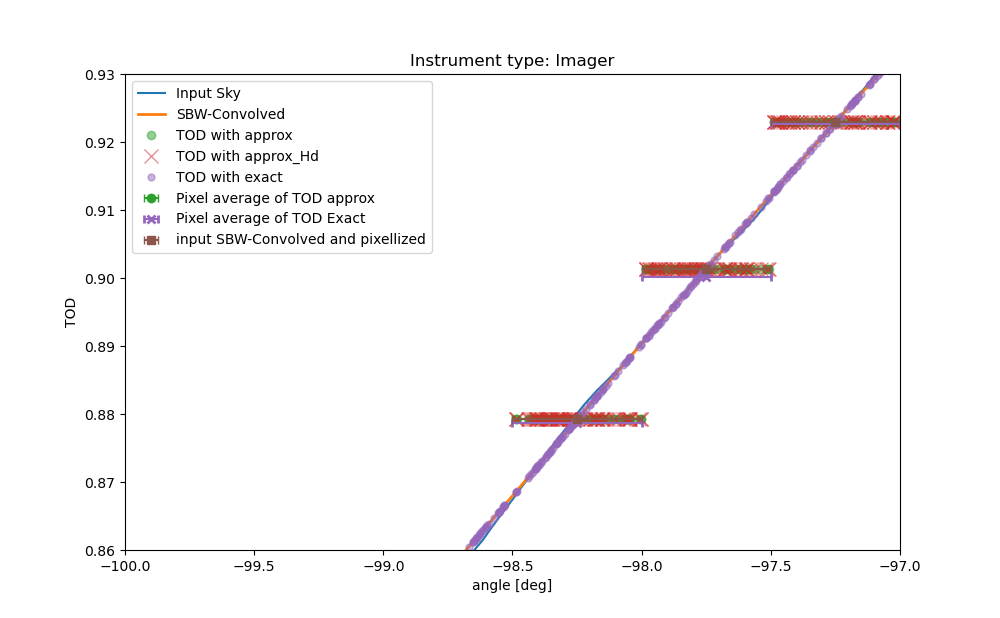

In [18]:
reload(q1d)

for type in ['BI', 'BI-GPA', 'Imager']:

    ######## approx Method ##########
    params = {'plot_reconstructed':False, 'TOD_method':'approx'}
    myinst_approx =  q1d.Q1D(instrument_type=type, plot_sb=False, params=params)
    TOD_approx = myinst_approx.simulate()
    convolved_approx = myinst_approx.convolved_sky
    convolved_pix_approx = myinst_approx.convolved_sky_pix
    dx = myinst_approx.rec_pix_centers[1] - myinst_approx.rec_pix_centers[0]
    xa, ya, _, _, _ = profile(myinst_approx.ptg_deg, TOD_approx[0,:], [-180, 180], myinst_approx.npix, plot=False)

    ######## approx_Hd Method ##########
    params = {'plot_reconstructed':False, 'TOD_method':'approx_Hd'}
    myinst_approx_Hd =  q1d.Q1D(instrument_type=type, plot_sb=False, params=params)
    TOD_approx_Hd = myinst_approx_Hd.simulate()

    ######## Exact Method ##########
    params = {'plot_reconstructed':False, 'TOD_method':'exact'}
    myinst_exact =  q1d.Q1D(instrument_type=type, plot_sb=False, params=params)
    TOD_exact = myinst_exact.simulate()
    xe, ye, _, _, _ = profile(myinst_exact.ptg_deg, TOD_exact[0,:], [-180, 180], myinst_exact.npix, plot=False)

    plt.figure()
    plt.plot(myinst_approx.input_sky[0], myinst_approx.input_sky[1], label='Input Sky')
    plt.plot(myinst_exact.input_sky[0], myinst_exact.SynthBeam_convolved, label='SBW-Convolved', lw=2)

    pa = plt.plot(myinst_approx.ptg_deg, TOD_approx[0,:], 'o', label='TOD with approx', alpha=0.5)
    ph = plt.plot(myinst_approx_Hd.ptg_deg, TOD_approx_Hd[0,:], 'x', ms=10, label='TOD with approx_Hd', alpha=0.5)
    pe = plt.plot(myinst_exact.ptg_deg, TOD_exact[0,:], '.', ms=10, label='TOD with exact', alpha=0.5)

    plt.errorbar(xa, ya, xerr=dx/2, fmt='o', capsize=3, label='Pixel average of TOD approx', color=pa[0].get_color())
    plt.errorbar(xe, ye, xerr=dx/2, fmt='x', capsize=3, mew=2, label='Pixel average of TOD Exact', color=pe[0].get_color())

    plt.errorbar(myinst_exact.rec_pix_centers, myinst_exact.SynthBeam_convolved_pix, xerr=dx/2, fmt='s', capsize=3, label='input SBW-Convolved and pixellized')

    plt.xlabel('angle [deg]')
    plt.ylabel('TOD')
    plt.title('Instrument type: '+type)
    plt.xlim(-100, -97)
    plt.ylim(0.86, 0.93)
    plt.legend()



## Analysis of the above plots:

1. Closeness to input sky: 

Not surprisingly, the TOD for an `Imager` follow closely the input sky, although convolved with the angular resolution. The TOD are more significantly different from the smoothed sky for a `BI` or a `BI-GPA` as the TOD incorporate information from the multiple peaks and is therefore a more complex mixture of the sky.

2. TOD realism:

For all intrument types, we see that the `exact` method, which directly uses samples the "sky convolved by the synthesized beam (be it multiply peaked or not) and by the pixel window function" interpolated at each pointing direction, results in a smooth TOD. It is very different for the `approx` (or `approx_Hd` which is equivalent but implemented using H) method wich is aimed at mimicking the reconstruction approximmations. We observe in each case that the dicretization of H that maps towards pixels results in a mismatch between the `exact` TOD and the ones approximated with H.

In the case of the `imager`, all samples falling into a given reconstructed pixel will have the eaxct same value in the `approx` case while in both `BI` and `BI-GPA` cases there are multiple discrete values within a pixel, corresponding to when the secondary peaks shift from one pixel to another while other peaks do not shift. 

Let's remark also that in ordinary 2D Healpix simulations, the input sky is always sampled from a pixellized healpix map usually at the same `nside` as the reconstructed map, whic is actually equivalent to our `approx` mwthod. If one were to do differently (using a higher `nside` map as an input) some mismatch effects would appear in the same way as here.

Finally, one would expect the average of the values picked for each pointing in the `exact` case to exctly match the value of the synthesized-beam-aned-pixel-convolved sjy, but this cannot be the case with a finite number of pointing whose average will fluctuate around this expectation value. Here again this is a small source of mismatch that would be negligible in the case of a very large number of pointings.

To conclude, this TOD realism issue appears in this simulation looks complicated and problematic at first sight but is is only because this 1D approach allows to do things in an exact manner and reveals small approximmations that are usually done witout even mentioning them. With real data, such mismatch will be present, but will be very small compared to the actual noise and as a result, are negligible. It is therefore fully justified to use the `approx` method here (and as said above, this is what is usually done in 2D helpix-based simulations).